# Modelos de regressão para séries temporal


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from pygam import LinearGAM, s
import numpy as np

## Dados

In [17]:
df = pd.read_csv("data_updated.csv")
df

,week,volume,inv,users
0,2022-10-31,0.38,1.609882,6.500
1,2022-11-07,0.47,1.880548,7.061
2,2022-11-14,0.32,2.297810,5.875
3,2022-11-21,1.69,5.623875,24.238
4,2022-11-28,1.23,1.473418,7.648
...,...,...,...,...
152,2025-09-29,20.33,1.144344,9.575
153,2025-10-06,14.50,0.520285,4.504
154,2025-10-13,17.89,0.837998,7.296
155,2025-10-20,24.52,1.422242,12.458



Plota volume, inv e users juntos no mesmo gráfico

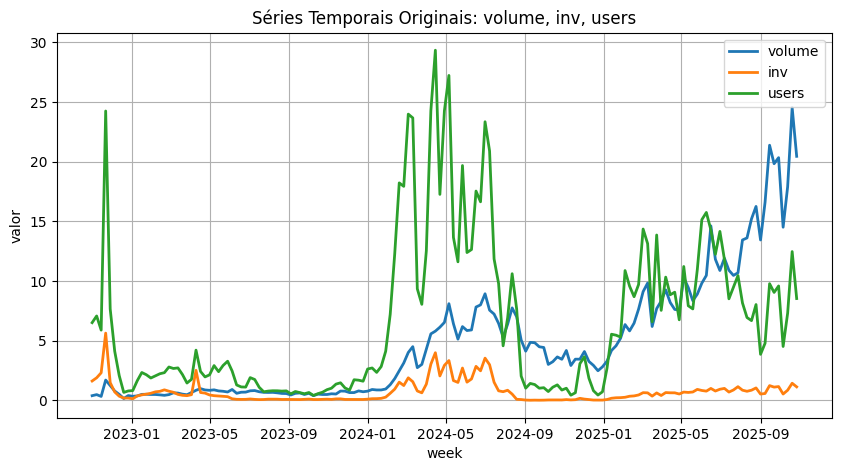

In [18]:
# Carrega dados
df = pd.read_csv("data_updated.csv", parse_dates=['week'])
df = df.sort_values("week").set_index("week")

# ---------- Plot das três séries no mesmo padrão ----------
plt.figure(figsize=(10,5))

plt.plot(df.index, df['volume'], label='volume', linewidth=2)
plt.plot(df.index, df['inv'], label='inv', linewidth=2)
plt.plot(df.index, df['users'], label='users', linewidth=2)

plt.title("Séries Temporais Originais: volume, inv, users")
plt.xlabel("week")
plt.ylabel("valor")
plt.grid(True)
plt.legend()
plt.show()


Explorando relações entre volume e outras variáveis: Scatter com reta de regressão entre volume e inv; volume e users

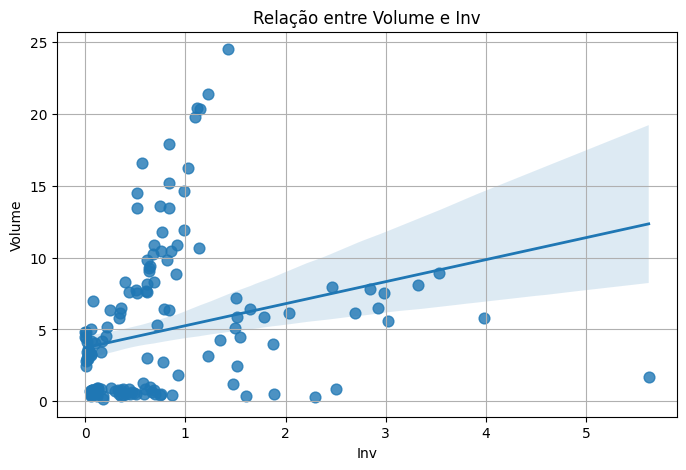

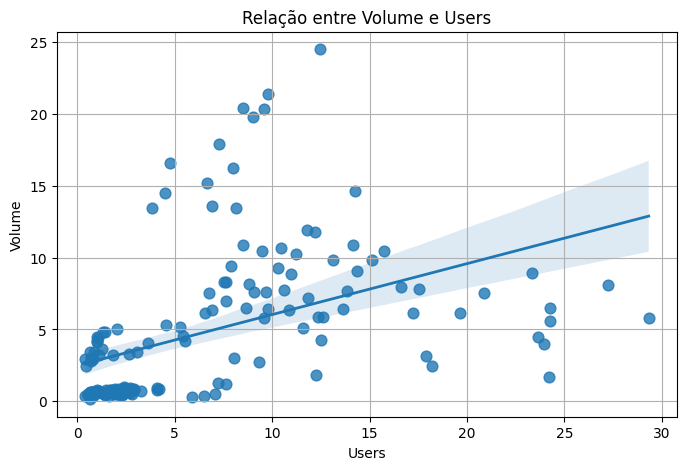

In [ ]:
df = pd.read_csv("data_updated.csv")
df['week'] = pd.to_datetime(df['week'])

# volume vs inv
plt.figure(figsize=(8,5))
sns.regplot(
    data=df,
    x='inv',
    y='volume',
    ci=95,       # intervalo de confiança
    scatter_kws={'s':60},
    line_kws={'linewidth':2}
)
plt.title("Relação entre Volume e Inv")
plt.xlabel("Inv")
plt.ylabel("Volume")
plt.grid(True)
plt.show()

#  volume vs users
plt.figure(figsize=(8,5))
sns.regplot(
    data=df,
    x='users',
    y='volume',
    ci=95,
    scatter_kws={'s':60},
    line_kws={'linewidth':2}
)
plt.title("Relação entre Volume e Users")
plt.xlabel("Users")
plt.ylabel("Volume")
plt.grid(True)
plt.show()


## Modelos de regressão

### Regressão linear simples

Ajustamos uma regressão linear simples que considera apenas a variável volume e a variável temporal

In [ ]:
df = pd.read_csv("data_updated.csv")

df['t'] = np.arange(1, len(df) + 1)       # tendência (t)
df.set_index('week', inplace=True)
# Garanta que o índice seja datetime
df.index = pd.to_datetime(df.index)


# -------------- Split treino/test --------------
test_size = 4   # últimas 4 observações como teste
train = df.iloc[:-test_size].copy()
test = df.iloc[-test_size:].copy()


In [ ]:
# -------------- Modelo 1: Regressão simples (volume ~ t) --------------
X_train_s = sm.add_constant(train['t'])
model_simple = sm.OLS(train['volume'], X_train_s).fit()

X_test_s = sm.add_constant(test['t'])
pred_test_simple = model_simple.get_prediction(X_test_s).summary_frame(alpha=0.05)  # 95% PI

# Forecast h passos à frente (só com t)
h = 4
last_t = df['t'].iloc[-1]
future_t = np.arange(last_t + 1, last_t + 1 + h)
X_future_s = sm.add_constant(future_t)
pred_future_simple = model_simple.get_prediction(X_future_s).summary_frame(alpha=0.05)

### Regressão linear múltipla

Ajustamos uma regressão linear múltipla que considera também as covariáveis inv e users 

In [ ]:
# -------------- Modelo 2: Regressão múltipla (volume ~ inv + users + t) --------------

# Observação importante: para prever mais à frente precisamos de inv/users futuros.
# Aqui usamos a suposição simples: inv e users futuros = último valor observado.
X_train_m = sm.add_constant(train[['inv', 'users', 't']])
model_multi = sm.OLS(train['volume'], X_train_m).fit()

X_test_m = sm.add_constant(test[['inv', 'users', 't']])
pred_test_multi = model_multi.get_prediction(X_test_m).summary_frame(alpha=0.05)

# Construir covariáveis futuras (assumindo inv/users constantes no último valor)
last_inv = df['inv'].iloc[-1]
last_users = df['users'].iloc[-1]
future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=7), periods=h, freq='W-MON')
future_df = pd.DataFrame({
    'inv': [last_inv]*h,
    'users': [last_users]*h,
    't': future_t
}, index=future_index)

# Garantir que exógena tem mesma coluna 'const' usada no modelo
X_future_m = future_df[['inv','users','t']].copy()
X_future_m.insert(0, 'const', 1.0)
# Reordenar colunas conforme o modelo (por segurança)
cols_expected = model_multi.model.exog_names
X_future_m = X_future_m[cols_expected]

pred_future_multi = model_multi.get_prediction(X_future_m).summary_frame(alpha=0.05)

#### Incluir efeito sazonal

Ajustamos uma regressão linear múltipla que considera também o efeito sazonal dos dados

(com tendência + múltipla + efeito sazonal)

In [ ]:
# -------------- Modelo 3: volume ~ inv + users + t + sazonalidade --------------

# Criar variável sazonal (mês)
df['season'] = df.index.month
all_seasons = sorted(df['season'].unique())
df['season'] = pd.Categorical(df['season'], categories=all_seasons)

# # Aplicar categorias no train e test

train['season'] = df['season'].iloc[:-test_size].copy()
train['season'] = pd.Categorical(train['season'], categories=all_seasons)

test['season']  = df['season'].iloc[-test_size:].copy()
test['season']  = pd.Categorical(test['season'], categories=all_seasons)


# Criar dummies (garantindo dtype numérico!)
season_dummies_train = pd.get_dummies(train['season'], prefix="season", drop_first=True).astype(float)
season_dummies_test  = pd.get_dummies(test['season'],  prefix="season", drop_first=True).astype(float)

# ---------- Construir X_train ----------
X_train_m3 = pd.concat(
    [train[['inv', 'users', 't']].astype(float), season_dummies_train],
    axis=1
)

X_train_m3 = sm.add_constant(X_train_m3.astype(float))

# Ajustar o modelo
model_multi_season = sm.OLS(train['volume'].astype(float), X_train_m3).fit()

# ---------- Construir X_test ----------
X_test_m3 = pd.concat(
    [test[['inv', 'users', 't']].astype(float), season_dummies_test],
    axis=1
)

# Garantir MESMAS colunas que o treino
X_test_m3 = X_test_m3.reindex(columns=X_train_m3.columns, fill_value=0).astype(float)

pred_test_multi_season = model_multi_season.get_prediction(X_test_m3).summary_frame(alpha=0.05)

# ---------- Futuro ----------
last_inv = df['inv'].iloc[-1]
last_users = df['users'].iloc[-1]

future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=7),
                             periods=h, freq='W-MON')

future_df = pd.DataFrame({
    'inv': [last_inv]*h,
    'users': [last_users]*h,
    't': future_t
}, index=future_index)

future_df['season'] = future_df.index.month
future_df['season'] = pd.Categorical(future_df['season'], categories=all_seasons)

season_dummies_future = pd.get_dummies(future_df['season'], prefix="season", drop_first=True).astype(float)

X_future_m3 = pd.concat(
    [future_df[['inv','users','t']].astype(float), season_dummies_future],
    axis=1
)

cols_expected_m3 = model_multi_season.model.exog_names

X_future_m3 = X_future_m3.reindex(columns=cols_expected_m3, fill_value=0).astype(float)

pred_future_multi_season = model_multi_season.get_prediction(X_future_m3).summary_frame(alpha=0.05)


## Resultados

In [ ]:
# -------------- Métricas --------------
rmse_simple = mean_squared_error(test['volume'], pred_test_simple['mean']) ** 0.5
rmse_multi = mean_squared_error(test['volume'], pred_test_multi['mean']) ** 0.5
rmse_multi_season = mean_squared_error(test['volume'], pred_test_multi_season['mean']) ** 0.5


# -------------- Resultados--------------
print("RMSE (simples)  :", rmse_simple)
print("RMSE (múltiplo) :", rmse_multi)
print("RMSE (múltiplo com tendência) :", rmse_multi_season)
print("\nResumo - modelo simples:\n", model_simple.summary())
print("\nResumo - modelo múltiplo:\n", model_multi.summary())
print("\nResumo - modelo múltiplo com tendência:\n", model_multi_season.summary())

# Mostrar tabelas: observados vs preditos (teste)
results_test = test[['volume','inv','users','t']].copy()
results_test['pred_simple'] = pred_test_simple['mean'].values
results_test['pi_lower_simple'] = pred_test_simple['obs_ci_lower'].values
results_test['pi_upper_simple'] = pred_test_simple['obs_ci_upper'].values

results_test['pred_multi'] = pred_test_multi['mean'].values
results_test['pi_lower_multi'] = pred_test_multi['obs_ci_lower'].values
results_test['pi_upper_multi'] = pred_test_multi['obs_ci_upper'].values

results_test['pred_multi_season'] = pred_test_multi['mean'].values
results_test['pi_lower_multi_season'] = pred_test_multi['obs_ci_lower'].values
results_test['pi_upper_multi_season'] = pred_test_multi['obs_ci_upper'].values

print("\nObservado vs Predito (conjunto de teste):")
print(results_test)

print("\nPrevisão futura (simples, {} semanas):".format(h))
print(pred_future_simple[['mean','obs_ci_lower','obs_ci_upper']])

print("\nPrevisão futura (múltipla, {} semanas, assumindo inv/users constantes):".format(h))
print(pred_future_multi[['mean','obs_ci_lower','obs_ci_upper']])


print("\nPrevisão futura (múltipla com tendência, {} semanas, assumindo inv/users constantes):".format(h))
print(pred_future_multi_season[['mean','obs_ci_lower','obs_ci_upper']])

RMSE (simples)  : 8.82415601339445
RMSE (múltiplo) : 8.07740866666893
RMSE (múltiplo com tendência) : 6.676417271803516

Resumo - modelo simples:
                             OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     349.9
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           3.71e-41
Time:                        12:17:58   Log-Likelihood:                -358.88
No. Observations:                 153   AIC:                             721.8
Df Residuals:                     151   BIC:                             727.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.

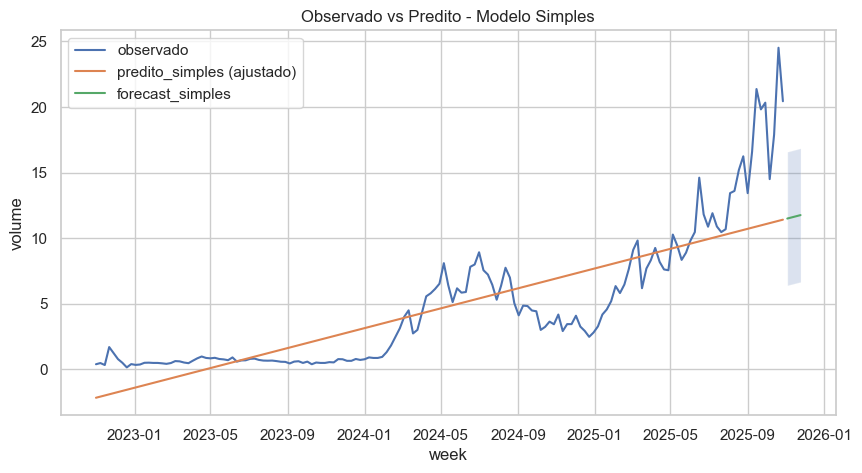

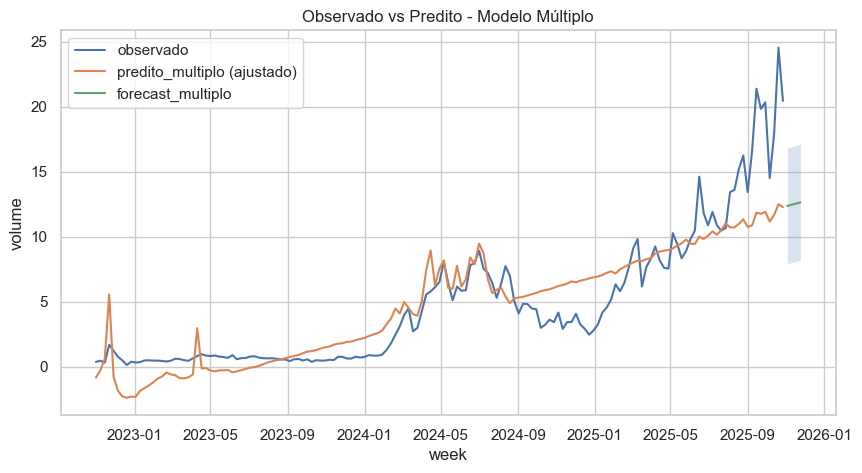

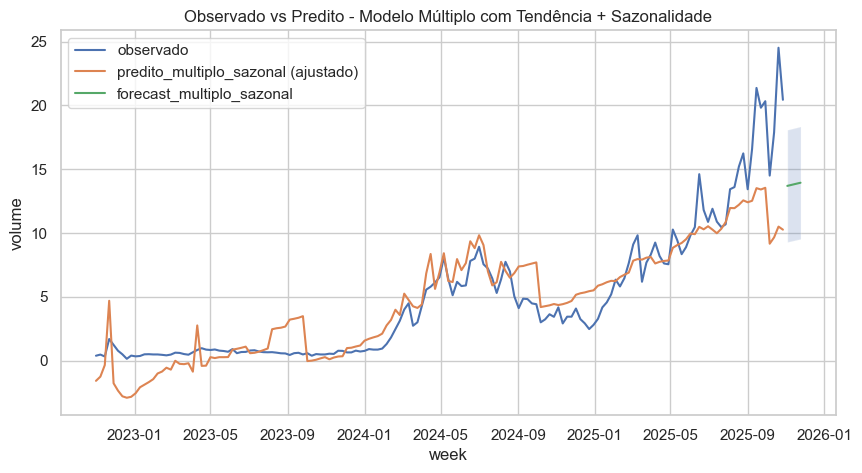


Sumários salvos em: summary_model_simple.txt, summary_model_multi.txt e summary_model_multi_season.txt


In [136]:
# -------------- Plots --------------
plt.figure(figsize=(10,5))
plt.plot(df.index, df['volume'], label='observado')
all_X_s = sm.add_constant(df['t'])
all_pred_s = model_simple.get_prediction(all_X_s).summary_frame(alpha=0.05)
plt.plot(df.index, all_pred_s['mean'], label='predito_simples (ajustado)')
plt.plot(future_index, pred_future_simple['mean'], label='forecast_simples')
plt.fill_between(future_index, pred_future_simple['obs_ci_lower'], pred_future_simple['obs_ci_upper'], alpha=0.2)
plt.legend()
plt.title('Observado vs Predito - Modelo Simples')
plt.xlabel('week')
plt.ylabel('volume')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(df.index, df['volume'], label='observado')
all_X_m = sm.add_constant(df[['inv','users','t']])
all_pred_m = model_multi.get_prediction(all_X_m).summary_frame(alpha=0.05)
plt.plot(df.index, all_pred_m['mean'], label='predito_multiplo (ajustado)')
plt.plot(future_index, pred_future_multi['mean'], label='forecast_multiplo')
plt.fill_between(future_index, pred_future_multi['obs_ci_lower'], pred_future_multi['obs_ci_upper'], alpha=0.2)
plt.legend()
plt.title('Observado vs Predito - Modelo Múltiplo')
plt.xlabel('week')
plt.ylabel('volume')
plt.grid(True)
plt.show()

# Criar dummies para todo df (exceto primeira categoria)
season_dummies_all = pd.get_dummies(df['season'], prefix="season", drop_first=True).astype(float)

# Construir exógenas completas
X_all_m3 = pd.concat([df[['inv','users','t']].astype(float), season_dummies_all], axis=1)
X_all_m3 = sm.add_constant(X_all_m3)

# Previsão ajustada (in-sample)
all_pred_m3 = model_multi_season.get_prediction(X_all_m3).summary_frame(alpha=0.05)

# Plot
plt.figure(figsize=(10,5))
plt.plot(df.index, df['volume'], label='observado')
plt.plot(df.index, all_pred_m3['mean'], label='predito_multiplo_sazonal (ajustado)')
plt.plot(future_index, pred_future_multi_season['mean'], label='forecast_multiplo_sazonal')
plt.fill_between(future_index, pred_future_multi_season['obs_ci_lower'], pred_future_multi_season['obs_ci_upper'], alpha=0.2)
plt.legend()
plt.title('Observado vs Predito - Modelo Múltiplo com Tendência + Sazonalidade')
plt.xlabel('week')
plt.ylabel('volume')
plt.grid(True)
plt.show()


# Salvar sumários
with open('summary_model_simple.txt','w') as f:
    f.write(model_simple.summary().as_text())
with open('summary_model_multi.txt','w') as f:
    f.write(model_multi.summary().as_text())
with open('summary_model_multi_season.txt','w') as f:
    f.write(model_multi_season.summary().as_text())

print("\nSumários salvos em: summary_model_simple.txt, summary_model_multi.txt e summary_model_multi_season.txt")


Scatter plot comparando valores reais vs valores ajustados (fitted)

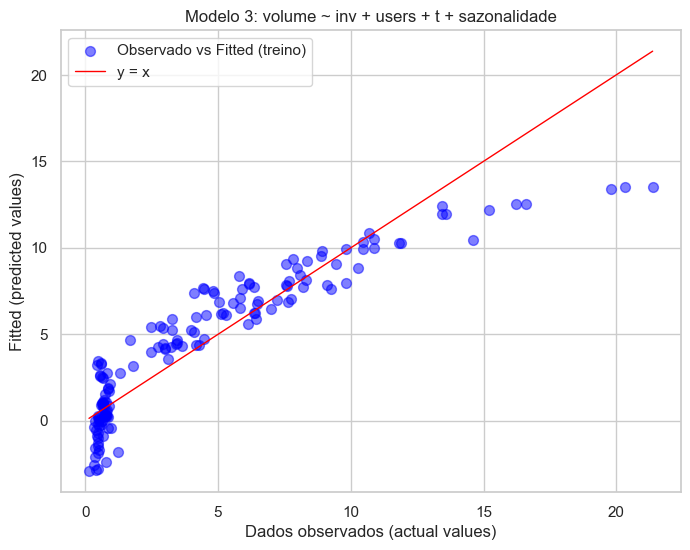

In [ ]:

# Valores ajustados (in-sample)
fitted_values = model_multi_season.fittedvalues

# Valores observados
observed_values = train['volume']

plt.figure(figsize=(8,6))
plt.scatter(observed_values, fitted_values, s=50, color='blue', alpha=0.5, label='Observado vs Fitted (treino)')
plt.plot([observed_values.min(), observed_values.max()],
         [observed_values.min(), observed_values.max()],
         color='red', linewidth=1, label='y = x')
plt.xlabel('Dados observados (actual values)')
plt.ylabel('Fitted (predicted values)')
plt.title('Modelo 3: volume ~ inv + users + t + sazonalidade')
plt.grid(True)
plt.legend()
plt.show()


### Resíduos de séries temporais com três gráficos típicos:

Resíduos ao longo do tempo

Histograma ou densidade

ACF (autocorrelação dos resíduos)

Gráficos para o modelo  mais completo, que teve menor erro

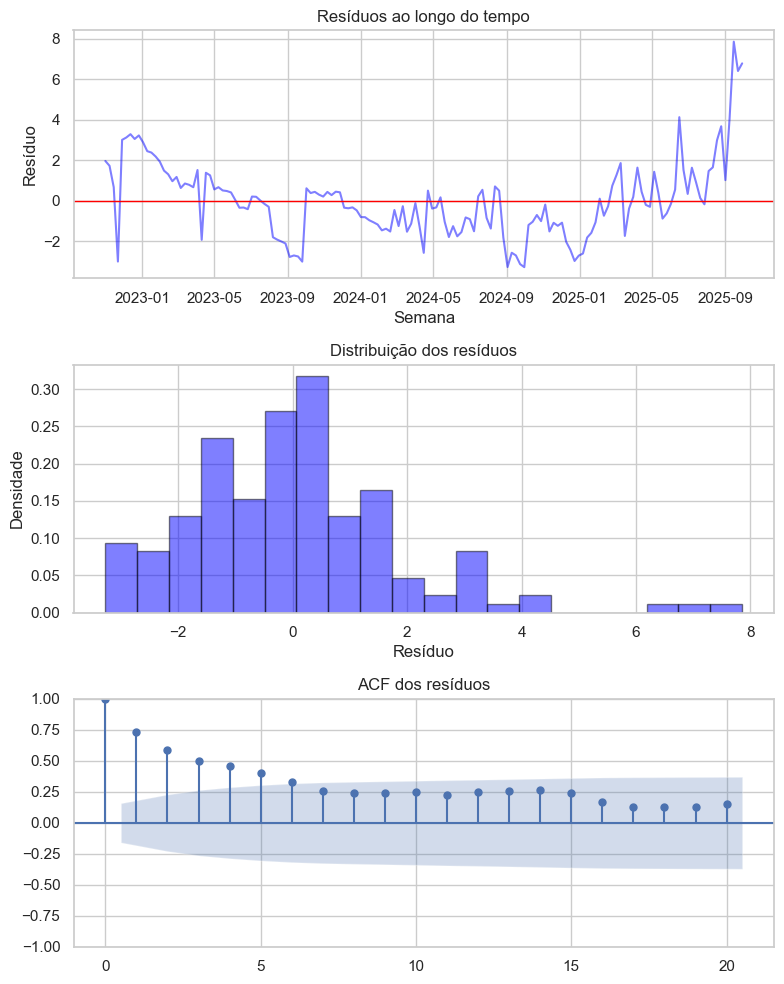

In [ ]:


residuals = model_multi_season.resid  # resíduos in-sample

fig, axs = plt.subplots(3, 1, figsize=(8,10))

# 1) Resíduos ao longo do tempo
axs[0].plot(residuals.index, residuals, color='blue', alpha = 0.5)
axs[0].axhline(0, color='red', linewidth=1)
axs[0].set_title('Resíduos ao longo do tempo')
axs[0].set_xlabel('Semana')
axs[0].set_ylabel('Resíduo')
axs[0].grid(True)

# 2) Histograma / densidade
axs[1].hist(residuals, bins=20, color='blue', edgecolor='black', density=True, alpha = 0.5)
axs[1].set_title('Distribuição dos resíduos')
axs[1].set_xlabel('Resíduo')
axs[1].set_ylabel('Densidade')
axs[1].grid(True)

# 3) ACF (autocorrelação)
sm.graphics.tsa.plot_acf(residuals, lags=20, ax=axs[2])
axs[2].set_title('ACF dos resíduos')

plt.tight_layout()
plt.show()


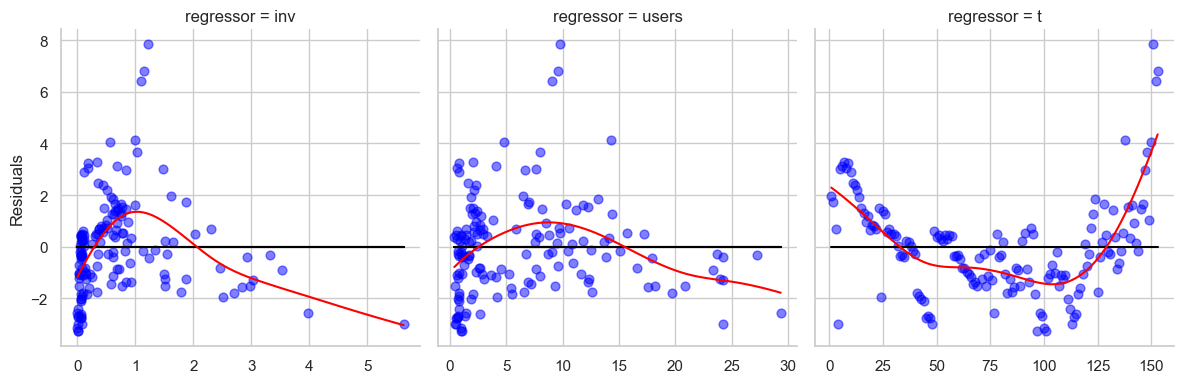

In [ ]:
# Criar dataframe apenas com o treino + resíduos
df_train_resid = train.copy()
df_train_resid['residuals'] = model_multi_season.resid.values

# Escolha das regressoras para plot (exemplo)
regressors = ['inv', 'users', 't']  # substitua/adapte conforme suas colunas

# Transformar para formato longo
df_long = df_train_resid.melt(id_vars=['residuals'], 
                              value_vars=regressors,
                              var_name='regressor', value_name='x')

# Configurar Seaborn
sns.set(style="whitegrid")

# FacetGrid para plotar cada regressora
g = sns.FacetGrid(df_long, col="regressor", col_wrap=3, sharex=False, sharey=True, height=4)

def scatter_with_smooth(data, **kwargs):
    x = data['x'].values
    y = data['residuals'].values
    
    # Scatter
    plt.scatter(x, y, s=40, alpha=0.5, color='blue')
    
    # Ajuste linear
    coef = np.polyfit(x, y, 1)
    y_lin = coef[0]*x + coef[1]
    plt.plot(x, y_lin, color='black', linewidth=1.5, label='Linear')
    
    # Ajuste GAM (spline cúbica)
    gam = LinearGAM(s(0, n_splines=10)).fit(x.reshape(-1,1), y)
    XX = np.linspace(x.min(), x.max(), 100)
    plt.plot(XX, gam.predict(XX), color='red', linewidth=1.5, label='GAM')
    
    plt.xlabel('')
    plt.ylabel('Residuals')
    plt.legend()

g.map_dataframe(scatter_with_smooth)

plt.tight_layout()
plt.show()


## Cross- validation no modelo de regressão multipla com tendência e sazonalidade

### TimeSeriesSplit (sklearn) 

Funciona como k-fold, mas preserva o tempo e usa janelas progressivas.

In [121]:
h = 4  # horizonte de previsão
rmse_scores = []

for train_idx, test_idx in tscv.split(X):

    # Usa APENAS as primeiras h observações do test set
    test_idx_h = test_idx[:h]

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx_h]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx_h]

    model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
    pred = model.predict(sm.add_constant(X_test))

    rmse = np.sqrt(mean_squared_error(y_test, pred))
    rmse_scores.append(rmse)

print("RMSE (h passos à frente):", rmse_scores)
print("RMSE médio:", np.mean(rmse_scores))


RMSE (h passos à frente): [np.float64(0.21190623582477444), np.float64(0.13393120301301714), np.float64(2.5810115340438813), np.float64(1.1055903584830775), np.float64(2.3367387672957833)]
RMSE médio: 1.2738356197321068


### Expanding Window CV (janela crescente)

Treina com um período crescente, testa no período seguinte.

TREINO: 1 2 3     | TESTE: 4

TREINO: 1 2 3 4   | TESTE: 5

TREINO: 1 2 3 4 5 | TESTE: 6


In [115]:
rmse_expanding = []

h = 4  # horizonte de previsão

for i in range(50, len(df)-h):  # começa com janela mínima (50)
    train = df.iloc[:i]
    test  = df.iloc[i:i+h]

    # X e y
    X_train = sm.add_constant(train[['inv','users','t']])
    y_train = train['volume']
    X_test = sm.add_constant(test[['inv','users','t']])

    model = sm.OLS(y_train, X_train).fit()
    pred = model.predict(X_test)

    rmse_expanding.append(np.sqrt(mean_squared_error(test['volume'], pred)))

print("RMSE médio (expanding window):", np.mean(rmse_expanding))


RMSE médio (expanding window): 2.1907702441699857


### Rolling Window CV (janela deslizante)

Treina sempre com o mesmo tamanho de janela.


TREINO: 1 2 3     | TESTE: 4

TREINO:   2 3 4   | TESTE: 5

TREINO:     3 4 5 | TESTE: 6


In [120]:
h = 4            # horizonte de previsão = 4 semanas
window = 52      # janela de treino = 1 ano
rmse_rolling = []

for i in range(window, len(df) - h):

    # ----- train e test -----
    train = df.iloc[i-window:i]
    test  = df.iloc[i:i+h]   # 4 semanas de teste

    # ----- X_train -----
    X_train = train[['inv','users','t']].astype(float)
    X_train = sm.add_constant(X_train, has_constant='add')
    y_train = train['volume']

    # ----- Ajustar modelo -----
    model = sm.OLS(y_train, X_train).fit()

    # ----- X_test -----
    X_test = test[['inv','users','t']].astype(float)
    X_test = sm.add_constant(X_test, has_constant='add')
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    # ----- Previsão para 4 semanas -----
    pred = model.predict(X_test)

    # ----- RMSE das 4 semanas -----
    rmse = np.sqrt(mean_squared_error(test['volume'], pred))
    rmse_rolling.append(rmse)

print("RMSE médio (rolling 4 semanas à frente):", np.mean(rmse_rolling))


RMSE médio (rolling 4 semanas à frente): 1.9277918404804297



RMSE CV (simples): 3.136411974963044

RMSE CV (múltiplo): 2.880190452282427

RMSE Teste (modelo CV simples): 4.667318383842773
RMSE Teste (modelo CV multipl0): 3.703045862529675

Resumo - CV simples:
                             OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     287.7
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           2.20e-22
Time:                        15:38:34   Log-Likelihood:                -103.44
No. Observations:                  52   AIC:                             210.9
Df Residuals:                      50   BIC:                             214.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
        

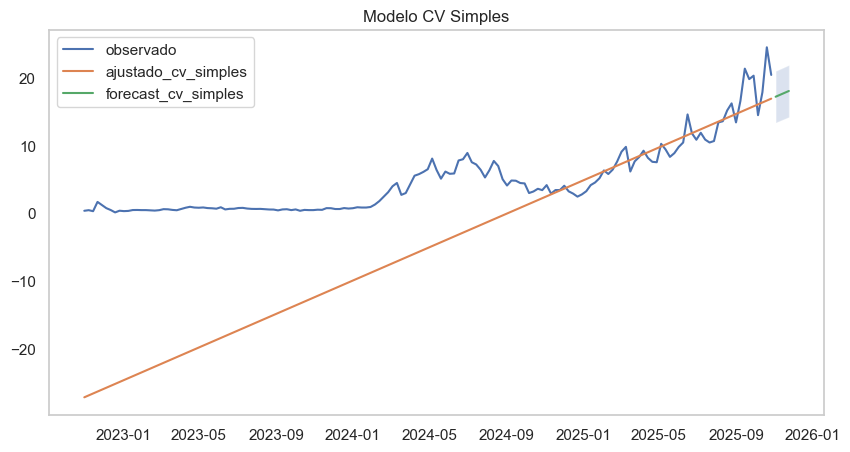

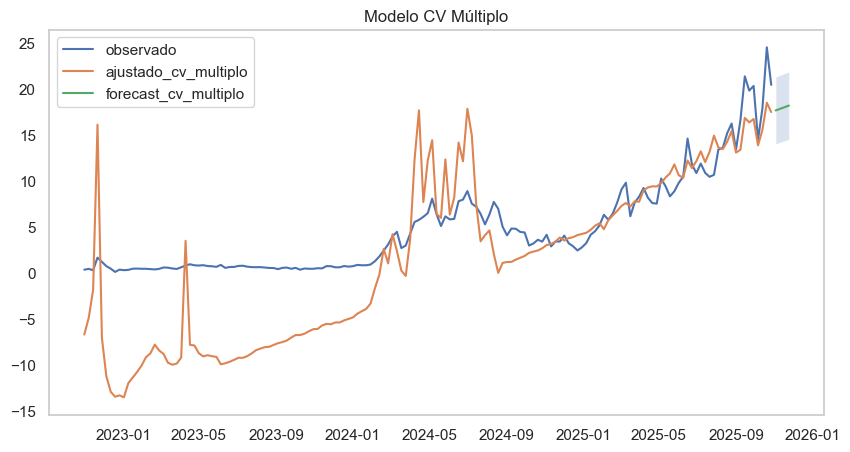


Sumários salvos: summary_cv_simple.txt e summary_cv_multi.txt


In [122]:
# ============================================================
#               CROSS-VALIDATION - MODELOS
# ============================================================
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

tscv = TimeSeriesSplit(n_splits=5)
h = 4  # horizonte de previsão

# ----------------------------------------------------------
#                   MODELO CV 1: volume ~ t
# ----------------------------------------------------------

X = df[['t']]
y = df['volume']

rmse_cv_simple = []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
    pred = model.predict(sm.add_constant(X_test))

    rmse_cv_simple.append(np.sqrt(mean_squared_error(y_test, pred)))

print("\nRMSE CV (simples):", np.mean(rmse_cv_simple))

# ---- Treinar modelo final (completo) ----
X_train_s = sm.add_constant(train['t'])
model_cv_simple = sm.OLS(train['volume'], X_train_s).fit()

# ---- Previsão no teste ----
X_test_s = sm.add_constant(test['t'])
pred_test_cv_simple = model_cv_simple.get_prediction(X_test_s).summary_frame(alpha=0.05)

# ---- Previsão futura ----
last_t = df['t'].iloc[-1]
future_t = np.arange(last_t + 1, last_t + 1 + h)
X_future_s = sm.add_constant(future_t)
pred_future_cv_simple = model_cv_simple.get_prediction(X_future_s).summary_frame(alpha=0.05)



# ----------------------------------------------------------
#           MODELO CV 2: volume ~ inv + users + t
# ----------------------------------------------------------

X = df[['inv','users','t']]
y = df['volume']

rmse_cv_multi = []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
    pred = model.predict(sm.add_constant(X_test))

    rmse_cv_multi.append(np.sqrt(mean_squared_error(y_test, pred)))

print("\nRMSE CV (múltiplo):", np.mean(rmse_cv_multi))

# ---- Treinar modelo final ----
X_train_m = sm.add_constant(train[['inv','users','t']])
model_cv_multi = sm.OLS(train['volume'], X_train_m).fit()

# ---- Previsão no teste ----
X_test_m = sm.add_constant(test[['inv','users','t']])
pred_test_cv_multi = model_cv_multi.get_prediction(X_test_m).summary_frame(alpha=0.05)

# ---- Previsão futura ----
last_inv = df['inv'].iloc[-1]
last_users = df['users'].iloc[-1]

future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=7),
                             periods=h, freq='W-MON')
future_df = pd.DataFrame({
    'inv': [last_inv]*h,
    'users': [last_users]*h,
    't': future_t
}, index=future_index)

X_future_m = future_df.copy()
X_future_m.insert(0, 'const', 1.0)
cols_expected = model_cv_multi.model.exog_names
X_future_m = X_future_m[cols_expected]

pred_future_cv_multi = model_cv_multi.get_prediction(X_future_m).summary_frame(alpha=0.05)



# ----------------------------------------------------------
#                     MÉTRICAS CV vs TESTE
# ----------------------------------------------------------

rmse_cv_simple_test = np.sqrt(mean_squared_error(test['volume'],
                                                pred_test_cv_simple['mean']))

rmse_cv_multi_test = np.sqrt(mean_squared_error(test['volume'],
                                               pred_test_cv_multi['mean']))

print("\nRMSE Teste (modelo CV simples):", rmse_cv_simple_test)
print("RMSE Teste (modelo CV multipl0):", rmse_cv_multi_test)
print("\nResumo - CV simples:\n", model_cv_simple.summary())
print("\nResumo - CV múltiplo:\n", model_cv_multi.summary())



# ----------------------------------------------------------
#             TABELA: Observado vs Predito (Teste)
# ----------------------------------------------------------

results_test_cv = test[['volume','inv','users','t']].copy()
results_test_cv['pred_simple_cv'] = pred_test_cv_simple['mean'].values
results_test_cv['pred_multi_cv'] = pred_test_cv_multi['mean'].values

print("\nObservado vs Predito (Modelos CV):")
print(results_test_cv)



# ============================================================
#                         PLOTS
# ============================================================

# ------------ Plot: Modelo CV Simples ------------
plt.figure(figsize=(10,5))
plt.plot(df.index, df['volume'], label='observado')

all_X_s = sm.add_constant(df[['t']])
all_pred_s = model_cv_simple.get_prediction(all_X_s).summary_frame(alpha=0.05)

plt.plot(df.index, all_pred_s['mean'], label='ajustado_cv_simples')
plt.plot(future_index, pred_future_cv_simple['mean'], label='forecast_cv_simples')
plt.fill_between(future_index,
                 pred_future_cv_simple['obs_ci_lower'],
                 pred_future_cv_simple['obs_ci_upper'],
                 alpha=0.2)

plt.title("Modelo CV Simples")
plt.legend()
plt.grid()
plt.show()


# ------------ Plot: Modelo CV Múltiplo ------------
plt.figure(figsize=(10,5))
plt.plot(df.index, df['volume'], label='observado')

all_X_m = sm.add_constant(df[['inv','users','t']])
all_pred_m = model_cv_multi.get_prediction(all_X_m).summary_frame(alpha=0.05)

plt.plot(df.index, all_pred_m['mean'], label='ajustado_cv_multiplo')
plt.plot(future_index, pred_future_cv_multi['mean'], label='forecast_cv_multiplo')
plt.fill_between(future_index,
                 pred_future_cv_multi['obs_ci_lower'],
                 pred_future_cv_multi['obs_ci_upper'],
                 alpha=0.2)

plt.title("Modelo CV Múltiplo")
plt.legend()
plt.grid()
plt.show()



# ----------------------------------------------------------
#               Salvar sumários
# ----------------------------------------------------------

with open('summary_cv_simple.txt','w') as f:
    f.write(model_cv_simple.summary().as_text())

with open('summary_cv_multi.txt','w') as f:
    f.write(model_cv_multi.summary().as_text())

print("\nSumários salvos: summary_cv_simple.txt e summary_cv_multi.txt")


RMSE médio - Rolling Window: 7.63663815651657
RMSE médio - Expanding Window: 1.3399067422737987
RMSE médio - TimeSeriesSplit: 2.880190452282427

===== COMPARAÇÃO FINAL =====
Rolling Window     RMSE = 7.6366
Expanding Window   RMSE = 1.3399
TimeSeriesSplit    RMSE = 2.8802


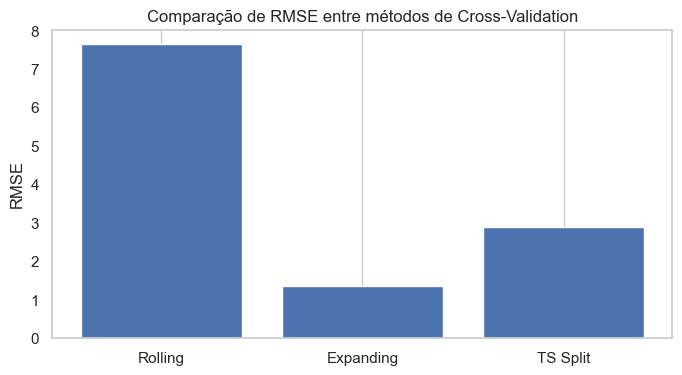


===== RESUMO Rolling Window =====

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     49.96
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           6.26e-11
Time:                        17:37:58   Log-Likelihood:                -59.040
No. Observations:                  30   AIC:                             126.1
Df Residuals:                      26   BIC:                             131.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -43

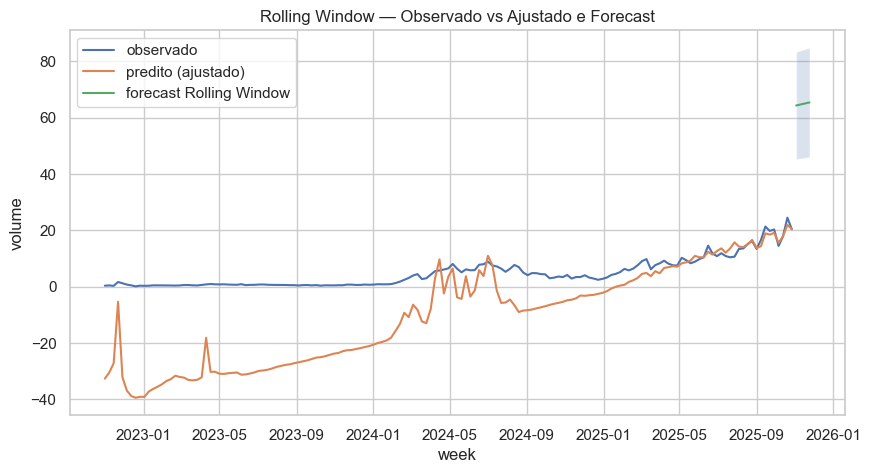


===== RESUMO Expanding Window =====

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     170.7
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           1.29e-48
Time:                        17:37:58   Log-Likelihood:                -364.60
No. Observations:                 157   AIC:                             737.2
Df Residuals:                     153   BIC:                             749.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

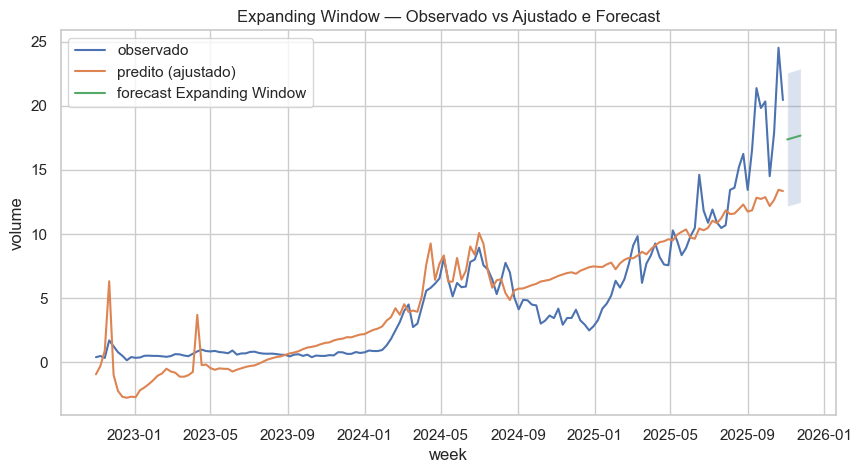


===== RESUMO TimeSeriesSplit =====

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     211.7
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           3.18e-49
Time:                        17:37:59   Log-Likelihood:                -202.09
No. Observations:                 131   AIC:                             412.2
Df Residuals:                     127   BIC:                             423.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -

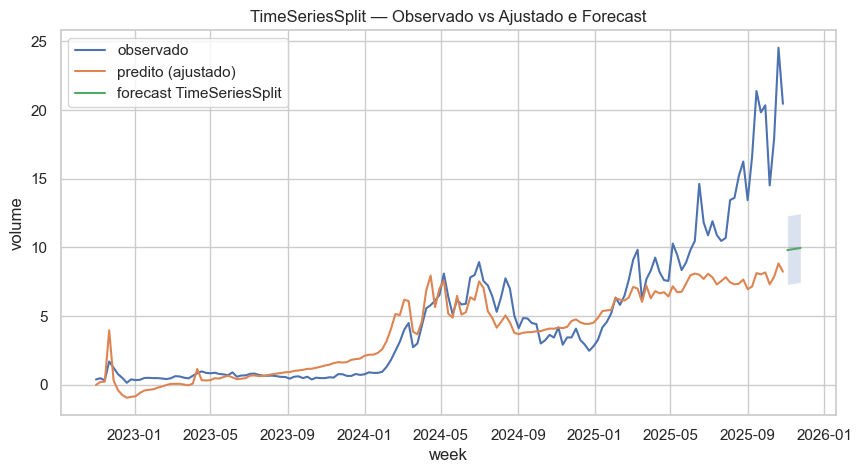

In [148]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# ================================================================
# CONFIGURAÇÕES
# ================================================================
X_cols = ['inv', 'users', 't']
target = 'volume'
h = 4  # horizonte de previsão
window = 30  # tamanho da janela para rolling

# Funções de erro
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true))*100

# Função auxiliar para alinhar colunas
def align_columns(X_test, X_train_cols):
    X_test = X_test.reindex(columns=X_train_cols, fill_value=0)
    return X_test

# ================================================================
# 1) ROLLING WINDOW
# ================================================================
rmse_rw_list = []
for end in range(window, len(df)):
    train_df = df.iloc[end-window:end]
    test_df = df.iloc[end:end+1]

    X_train = sm.add_constant(train_df[X_cols])
    y_train = train_df[target]

    model = sm.OLS(y_train, X_train).fit()

    X_test = sm.add_constant(test_df[X_cols])
    X_test = align_columns(X_test, X_train.columns)
    pred = model.predict(X_test)

    rmse_rw_list.append(np.sqrt(mean_squared_error(test_df[target], pred)))

rmse_rw_mean = np.mean(rmse_rw_list)
print("RMSE médio - Rolling Window:", rmse_rw_mean)

# Modelo final Rolling Window (para plot)
model_final_rw = sm.OLS(df[target].iloc[-window:], sm.add_constant(df[X_cols].iloc[-window:])).fit()

# ================================================================
# 2) EXPANDING WINDOW
# ================================================================
rmse_exp_list = []
for end in range(window, len(df)):
    train_df = df.iloc[:end]
    test_df = df.iloc[end:end+1]

    X_train = sm.add_constant(train_df[X_cols])
    y_train = train_df[target]

    model = sm.OLS(y_train, X_train).fit()

    X_test = sm.add_constant(test_df[X_cols])
    X_test = align_columns(X_test, X_train.columns)
    pred = model.predict(X_test)

    rmse_exp_list.append(np.sqrt(mean_squared_error(test_df[target], pred)))

rmse_exp_mean = np.mean(rmse_exp_list)
print("RMSE médio - Expanding Window:", rmse_exp_mean)

# Modelo final Expanding Window (para plot)
model_final_exp = sm.OLS(df[target], sm.add_constant(df[X_cols])).fit()

# ================================================================
# 3) TIME SERIES SPLIT
# ================================================================
tscv = TimeSeriesSplit(n_splits=5)
rmse_tscv_list = []

for train_idx, test_idx in tscv.split(df):
    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    X_train = sm.add_constant(train_df[X_cols])
    y_train = train_df[target]

    model = sm.OLS(y_train, X_train).fit()

    X_test = sm.add_constant(test_df[X_cols])
    X_test = align_columns(X_test, X_train.columns)
    pred = model.predict(X_test)

    rmse_tscv_list.append(np.sqrt(mean_squared_error(test_df[target], pred)))

rmse_tscv_mean = np.mean(rmse_tscv_list)
print("RMSE médio - TimeSeriesSplit:", rmse_tscv_mean)

# Modelo final TimeSeriesSplit (último fold)
train_idx, test_idx = list(tscv.split(df))[-1]
model_final_tscv = sm.OLS(df[target].iloc[train_idx], sm.add_constant(df[X_cols].iloc[train_idx])).fit()

# ================================================================
# COMPARAÇÃO FINAL DE ERROS
# ================================================================
print("\n===== COMPARAÇÃO FINAL =====")
print(f"Rolling Window     RMSE = {rmse_rw_mean:.4f}")
print(f"Expanding Window   RMSE = {rmse_exp_mean:.4f}")
print(f"TimeSeriesSplit    RMSE = {rmse_tscv_mean:.4f}")

plt.figure(figsize=(8,4))
plt.bar(
    ['Rolling', 'Expanding', 'TS Split'],
    [rmse_rw_mean, rmse_exp_mean, rmse_tscv_mean]
)
plt.title("Comparação de RMSE entre métodos de Cross-Validation")
plt.ylabel("RMSE")
plt.grid(axis='y')
plt.show()

# ================================================================
# PREVISÕES E PLOTS
# ================================================================
future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=7), periods=h, freq='W-MON')
future_df = pd.DataFrame({
    'inv': [df['inv'].iloc[-1]]*h,
    'users': [df['users'].iloc[-1]]*h,
    't': np.arange(df['t'].iloc[-1]+1, df['t'].iloc[-1]+1+h)
}, index=future_index)

def plot_model(model, df, future_df, X_cols, model_name):
    all_X = sm.add_constant(df[X_cols])
    all_X = all_X.reindex(columns=model.model.exog_names, fill_value=0)
    pred_in = model.get_prediction(all_X).summary_frame(alpha=0.05)

    X_future = sm.add_constant(future_df[X_cols])
    X_future = X_future.reindex(columns=model.model.exog_names, fill_value=0)
    pred_future = model.get_prediction(X_future).summary_frame(alpha=0.05)

    # Print resumo
    print(f"\n===== RESUMO {model_name} =====\n")
    print(model.summary())

    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(df.index, df['volume'], label='observado')
    plt.plot(df.index, pred_in['mean'], label='predito (ajustado)')
    plt.plot(future_df.index, pred_future['mean'], label=f'forecast {model_name}')
    plt.fill_between(future_df.index,
                     pred_future['obs_ci_lower'],
                     pred_future['obs_ci_upper'], alpha=0.2)
    plt.legend()
    plt.title(f'{model_name} — Observado vs Ajustado e Forecast')
    plt.xlabel('week')
    plt.ylabel('volume')
    plt.grid(True)
    plt.show()

# Plots dos três modelos
plot_model(model_final_rw, df, future_df, X_cols, 'Rolling Window')
plot_model(model_final_exp, df, future_df, X_cols, 'Expanding Window')
plot_model(model_final_tscv, df, future_df, X_cols, 'TimeSeriesSplit')
